# Project: Time Series Forecasting of Taxi Orders for Peak Hour Prediction

### Introduction.
Sweet Lift Taxi Company has gathered historical data on taxi orders at airports with the goal of optimizing driver allocation during peak hours. To achieve this, we need to predict the number of taxi orders for the upcoming hour. This project focuses on analyzing and forecasting time series data, using a series of modeling techniques to uncover patterns and trends.

The data was first preprocessed and resampled to ensure consistency and to address any irregularities. We then decomposed the time series to isolate its underlying components—trend, seasonality, and residuals—to better understand its behavior. Autocorrelation (ACF) and partial autocorrelation (PACF) plots were also generated to explore temporal relationships and dependencies within the data.

We implemented four time series models—Autoregressive (AR), Autoregressive with Hyperparameter Optimization, Moving Average (MA), and ARMA—to forecast future taxi orders. Model performance was assessed using the Root Mean Squared Error (RMSE) metric, with all models meeting the project’s target of achieving an RMSE below 48 on a 10% holdout test set.

## Preparation

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import arma_order_select_ic
from pmdarima import auto_arima

In [5]:
data = pd.read_csv('taxi.csv',  index_col=[0], parse_dates=[0])

print(data.info())
print(data.head())
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


num_orders    0
dtype: int64

In [6]:
# here we check if the time is in chronological order:
data.sort_index()
print(data.index.is_monotonic_increasing)

True


## Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_1445/2305359859.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resample = data.resample('1H').sum()
/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_1445/2305359859.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_resample = data_resample.rolling(2).mean().fillna(method='bfill')


<Axes: xlabel='datetime'>

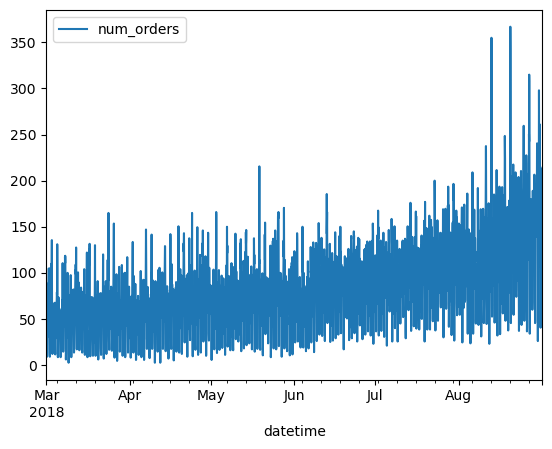

In [8]:
# Resampling for hourly data

data_resample = data.resample('1H').sum()

#rolling mean the data (to keep the details of the data we rolled it with just parameter two)
data_resample = data_resample.rolling(2).mean().fillna(method='bfill')

data_resample.isna().sum()        # no missing values
data_resample.info()
data_resample.plot()


#### The plot shows that the data is a nonstationary with a rising trend. To see this in detail, below we decompose the data

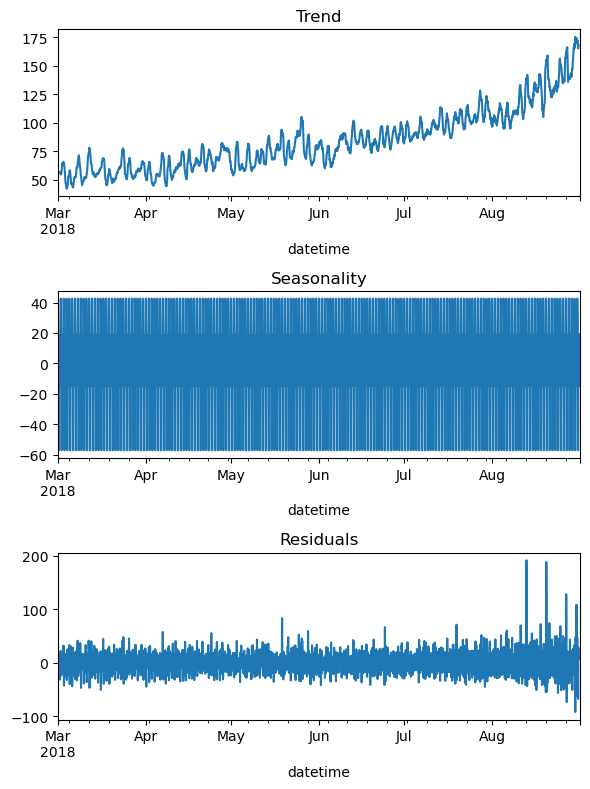

In [10]:
data_decomp = seasonal_decompose(data_resample)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
data_decomp.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
data_decomp.seasonal.plot(ax=plt.gca()) # < write code here >
plt.title('Seasonality')
plt.subplot(313)
data_decomp.resid.plot(ax=plt.gca())# < write code here >
plt.title('Residuals')
plt.tight_layout()


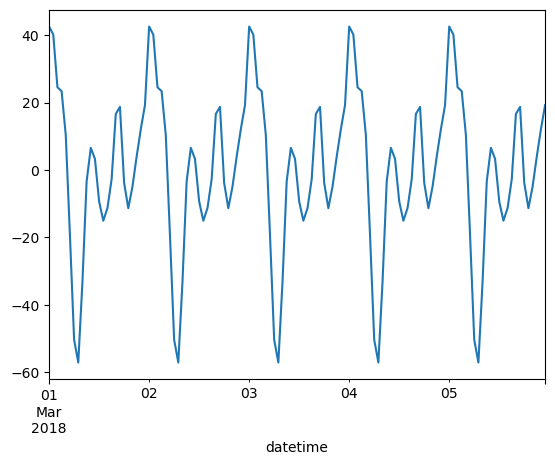

In [11]:
# here, by considering five days, we can see the details of seasonal behavior of the data. 
data_season = data_decomp.seasonal['2018-03-01':'2018-03-05'].plot()


#### The above shown plot demonstrates the 24 hour seasonality. 

# Nonstationary-to-stationary data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
 1   mean        4402 non-null   float64
 2   std         4402 non-null   float64
dtypes: float64(3)
memory usage: 138.0 KB


<Axes: xlabel='datetime'>

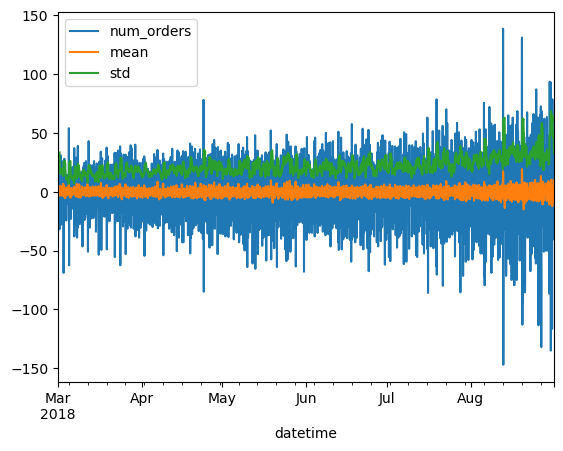

In [14]:
# we convert the non-stationary data into to statioanry using shift()

data_shift = data_resample.shift(fill_value=0)
data_stationary = data_resample-data_shift

#data_stationary_rolling = data_stationary.rolling(2).mean().fillna(method='bfill')

# mean value and std valus
data_stationary['mean'] = data_stationary['num_orders'].rolling(15).mean()
data_stationary['std'] = data_stationary['num_orders'].rolling(15).std()
data_stationary.info()
data_stationary.plot()


# Autoregression

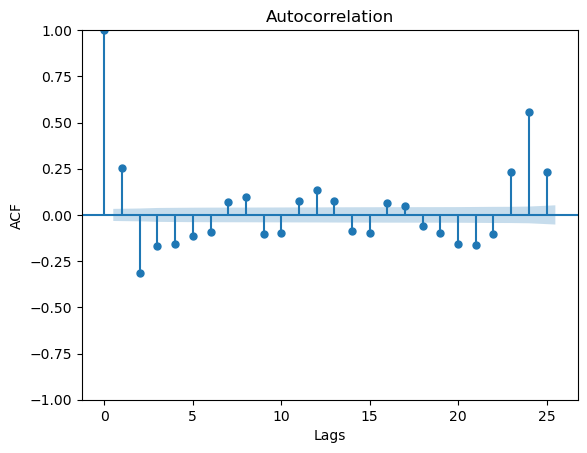

In [16]:
# we will analyse the data. first, we split the data into train, validation and test sets with 'shuffle=False'

train_valid, test = train_test_split(data_stationary, shuffle=False, test_size=0.10)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.10)

#acf = plot_acf(x=train['num_orders'], lags = 30)
acf = plot_acf(x=train['num_orders'], lags = 25)

plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

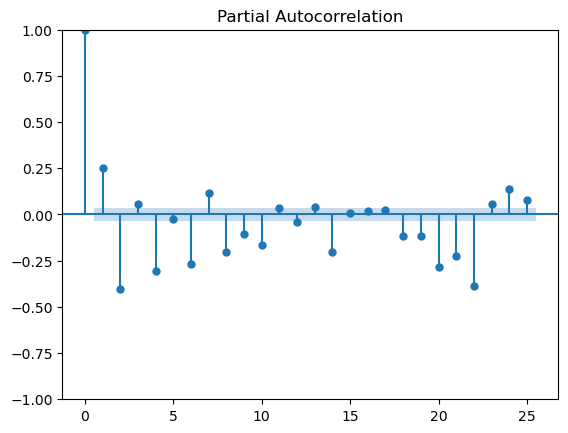

In [17]:
pacf = plot_pacf(x=train['num_orders'], lags=25)

### ACF plot shows the 15 significant spikes (we exclude the spike at lag=0).  PACF plot shows four significant spikes (we exclude the spike at lag=0). 

## Training

In [20]:
#  1) AR model training. Here, we take AR model order=7 because of number of significant spikes in PACF is 4 ( excluding the spike at lag=0) 

model_ar = AutoReg(train['num_orders'], lags=4, seasonal=True)
fit_ar = model_ar.fit()
    
# Prediction using validation set
start_value = len(train)
end_value = len(train) + len(valid) - 1

predictions_ar = fit_ar.predict(start=start_value, end=end_value)

rmse_ar = np.sqrt(mean_squared_error(valid['num_orders'], predictions_ar))

print(f"RMSE for AR model (PACF derived order=4) prediction on validation set: {rmse_ar:.4f}") 

RMSE for AR model (PACF derived order=4) prediction on validation set: 22.1655


###### RMSE for AR model (PACF derived order=4) prediction on validation set: 22.1615

In [22]:
#  2) AR model by finding its order using ar_select_order() function 

model_ars = ar_select_order(endog=train['num_orders'], maxlag=50)
ar_order = model_ars.ar_lags
print("Lags that define the AutoReg model order:", ar_order)

# Fit the AR model using the training set
ar_model = AutoReg(train['num_orders'], lags=ar_order)
ar_fit = ar_model.fit()  # Corrected to fit ar_model

# Predicting on validation set
start_value = len(train)
end_value = start_value + len(valid) - 1
predictions_ars = ar_fit.predict(start=start_value, end=end_value)  # Corrected to use ar_fit

# Calculate RMSE
rmse_ars = np.sqrt(mean_squared_error(valid['num_orders'], predictions_ars))

print()
print(f"RMSE for AR model (using ar_select_order() function order) prediction on validation set: {rmse_ars:.4f}")

Lags that define the AutoReg model order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]

RMSE for AR model (using ar_select_order() function order) prediction on validation set: 24.9611


###### RMSE for AR model (using ar_select_order() function order) prediction on validation set: 24.9611

In [ ]:
#. 3) MA model with arma_order_select_ic() function to find the the best model order

res = arma_order_select_ic(y=train['num_orders'], max_ar=0, max_ma=15)
ma_order = res.bic_min_order[1]

# Create and fit the MA model
ma_model = ARIMA(train['num_orders'], order=(0, 0, ma_order))  
ma_model_fit = ma_model.fit() 

# Make predictions on the validation set
start_value = len(train) 
end_value = start_value + len(valid) - 1  
ma_pred = ma_model_fit.predict(start=start_value, end=end_value, dynamic=False)

# Calculate RMSE of predictions
ma_rmse = mean_squared_error(valid['num_orders'], ma_pred, squared=False)

# Print the RMSE and the order
print(f"RMSE for MA model prediction on validation set: {ma_rmse:.4f} with order=(0, 0, {ma_order})")


#### RMSE for MA model (order = (0, 0, 12)) prediction on validation set = 29.2480

In [ ]:
# 4) ARMA model with hyperparameters: order = (4, 0, 15)

order = (4, 0, 15) 
arima_model = ARIMA(train['num_orders'], order=order)
arima_fit = arima_model.fit()

# Make predictions on the validation set
predictions = arima_fit.forecast(steps=len(valid))

# Calculate RMSE of predictions
rmse = mean_squared_error(valid['num_orders'], predictions, squared=False)

# Print the RMSE result
print(f"RMSE for ARIMA model (order={order}) prediction on validation set: {rmse:.4f}")

###### RMSE for ARIMA model (order=(7, 0, 15)) prediction on validation set: 27.7354

## Testing

In [ ]:
#  1) AR model prediction on test set. Here, we take AR model order=7 because of number of significant spikes in PACF is 4 ( excluding the spike at lag=0) 

start_test = len(train) + len(valid)
end_test = start_test + len(test) - 1
predictions_ar_test = fit_ar.predict(start=start_test, end=end_test)

# RMSE for test set

rmse_ar_test = np.sqrt(mean_squared_error(test['num_orders'], predictions_ar_test))

print(f"RMSE for AR model (PACF derived order=7) prediction on test set: {rmse_ar_test:.4f}")
    

In [ ]:
#. 2) AR model with ar_select_order() function 

start_value_test = len(train) + len(valid)
end_value_test = start_value_test + len(test) - 1
predictions_ars_test = ar_fit.predict(start=start_value_test, end=end_value_test)

# RMSE for test set

rmse_ars_test = np.sqrt(mean_squared_error(test['num_orders'], predictions_ars_test))

print(f"RMSE for AR model prediction on test set: {rmse_ars_test:.4f}")

In [ ]:
# 3) MA model with order=(0, 0, 12) found by arma_order_select_ic() function 

start_value_test = len(train) + len(valid)  
end_value_test = start_value_test + len(test) - 1 
ma_pred_test = ma_model_fit.predict(start=start_value_test, end=end_value_test, dynamic=False)

# RMSE of predictions for test set

ma_rmse_test = mean_squared_error(test['num_orders'], ma_pred_test, squared=False)

print(f"RMSE for MA model prediction on test set: {ma_rmse_test:.4f} with order=(0, 0, {ma_order})")

In [ ]:
# 4) ARMA model with hyperparameters: order = (4, 0, 15)

predictions_test = arima_fit.forecast(steps=len(test))

# RMSE of predictions for test set

rmse_test = mean_squared_error(test['num_orders'], predictions_test, squared=False)

print(f"RMSE for ARIMA model (order={order}) prediction on test set: {rmse_test:.4f}")

### Conclusion.

In this project, we successfully preprocessed the time series data, performing necessary resampling to address any gaps or inconsistencies. By decomposing the data, we extracted the trend, seasonality, and residual components, which allowed us to gain deeper insights into the underlying patterns. The autocorrelation (ACF) and partial autocorrelation (PACF) plots revealed important temporal relationships, guiding the selection of appropriate model parameters.

We applied four different time series models:

Autoregressive (AR) Model: The order was determined based on the PACF plot.
Autoregressive (AR) Model with Hyperparameter Optimization: Hyperparameters were fine-tuned using the ar_select_order() function for improved model performance.
Moving Average (MA) Model: The order (0, 0, 12) was selected using the arma_order_select_ic() function.
ARMA Model: The optimal order of (4, 0, 15) was selected based on model performance.
For evaluation, we reserved 10% of the data for testing and assessed model performance using Root Mean Squared Error (RMSE). All four models achieved RMSE values below the target threshold of 48, demonstrating their ability to predict taxi orders with high accuracy.


# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48